# Calibrate GAM and NGAM

In [1]:
import pandas as pd
from reframed import FBA, Environment, load_cbmodel, save_cbmodel
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import r2_score

In [2]:
model = load_cbmodel('../models/RcH10_v2.xml')

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media_cellb = media[media.medium=='DM_cellobiose']
env_cellb = Environment.from_compounds(list(media_cellb['compound']))
env_cellb["R_EX_h2o_e"]=(-1000,1000)
env_cellb["R_EX_h_e"]=(-1000,1000)
env_cellb.apply(model, inplace=True, exclusive=True, warning=False)

In [4]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet1', header=None, index_col=0, usecols="A:H")
mu = chemostat.iloc[0,:].values
q_cellb = chemostat.iloc[1,:].values

q_ac = chemostat.iloc[2,:].values * chemostat.iloc[3,:].values / 100
q_lac = chemostat.iloc[2,:].values * chemostat.iloc[4,:].values / 100
q_etoh = chemostat.iloc[2,:].values * chemostat.iloc[5,:].values / 100

### Estimating in comparison to growth rate

In [5]:
env_cellb.apply(model, inplace=True, exclusive=True, warning=False)

#Setting NGAM values in the ATPM function
mu_sim_alternatives = {}

for GAM in np.linspace(10,50,1000):
    
    model.reactions.R_ATPM.lb = 2.2
    model.reactions.R_Growth.stoichiometry['M_atp_c']=-GAM
    model.reactions.R_Growth.stoichiometry['M_adp_c']=GAM
    model.reactions.R_Growth.stoichiometry['M_h_c']=GAM
    model.reactions.R_Growth.stoichiometry['M_pi_c']=GAM

    # predict max growth rate (secretion is constrained)
    mu_sim = []

    for i, mu_i in enumerate(mu):
        constraints = {
            'R_EX_cellb_e': (-q_cellb[i], -q_cellb[i]),
            'R_EX_ac_e':(q_ac[i], q_ac[i]),
            'R_EX_lac__L_e':(q_lac[i], q_lac[i]),
            'R_EX_etoh_e':(q_etoh[i], q_etoh[i]),
        }
        sol = FBA(model, constraints=constraints)
        mu_i = sol.fobj if sol.fobj is not None else 0
        mu_sim.append(mu_i)
        
    sum_squared_error = np.sum(np.square(mu - mu_sim))
    mu_sim_alternatives[(GAM)] = sum_squared_error

In [6]:
#Setting NGAM values in the ATPM function

model.reactions.R_ATPM.lb =2.2
mu_sim_alternative_df = pd.Series(mu_sim_alternatives)
GAM = round(mu_sim_alternative_df.sort_values(ascending=True).index[0],2)

model.reactions.R_Growth.stoichiometry['M_atp_c']=-GAM
model.reactions.R_Growth.stoichiometry['M_adp_c']=GAM
model.reactions.R_Growth.stoichiometry['M_h_c']=GAM
model.reactions.R_Growth.stoichiometry['M_pi_c']=GAM

print(f"GAM: {GAM}, and NGAM:{2.2}")

GAM: 29.54, and NGAM:2.2


In [7]:
# predict max growth rate (secretion is constrained)
mu_sim = []

for i, mu_i in enumerate(mu):
    constraints = {
        'R_EX_cellb_e': (-q_cellb[i], -q_cellb[i]),
        'R_EX_ac_e':(q_ac[i], q_ac[i]),
        'R_EX_lac__L_e':(q_lac[i], q_lac[i]),
        'R_EX_etoh_e':(q_etoh[i], q_etoh[i]),
    }
    sol = FBA(model, constraints=constraints)
    mu_i = sol.fobj if sol.fobj is not None else 0
    mu_sim.append(mu_i)

In [8]:

r2 = r2_score(mu,mu_sim)
print(f"Sum of squares: {np.sum(np.square(mu - mu_sim))} and r2 {r2}")

Sum of squares: 0.0018508386441153718 and r2 0.845062538760971


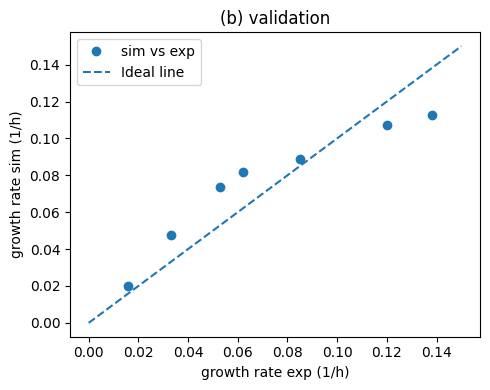

In [9]:
fig, axs = plt.subplots(1,1, figsize=(5,4))


axs.plot(mu, mu_sim, 'o',label="sim vs exp")
axs.plot(np.linspace(0,0.15,100), np.linspace(0,0.15,100),'--',color="tab:blue",label="Ideal line")
axs.legend()
axs.set_ylabel('growth rate sim (1/h)')
axs.set_xlabel('growth rate exp (1/h)')
axs.set_title('(b) validation')

fig.tight_layout()
fig.savefig('../figures/gam_ngam_calibration.png', dpi=300)

#### Save model

In [10]:
model.update()

save_cbmodel(model, '../models/RcH10_v3.xml')